# 謝辞


本ノートブックは，日本船舶海洋工学会の主催する第３５４回KFRセミナー「船舶海洋工学者のためのブラックボックス最適化セミナー」にて使用するために取りまとめたものである．以前よりこのような実践ガイドを作成して公開したいと思っていたが，今回のような機会がなかったらいつまでも完成させられずにいたと思う．本セミナーを企画し，今回のような機会を与えてくれた大阪大学の牧敦生先生には深く感謝する．

# 目的

勾配を用いない最適化法であるCMA-ESを利用している応用側の研究者から，「CMA-ESを用いてみたが，望ましい解が得られない」といった相談やコメントをしばしばいただきます．ここでは，CMA-ESをうまく活用するための設定，実験結果から問題の性質についての分析，問題定式化の検討の観点から，私の経験則をまとめます．

# 参考資料

この資料は，著者らが毎年国際会議GECCOにおいて開催しているCMA-ESチュートリアルを参考にしています．

Youhei Akimoto and Nikolaus Hansen. 2022. CMA-ES and advanced adaptation mechanisms. In Proceedings of the Genetic and Evolutionary Computation Conference Companion (GECCO '22). Association for Computing Machinery, New York, NY, USA, 1243–1268. https://doi.org/10.1145/3520304.3533648
チュートリアル動画：https://www.youtube.com/watch?v=7VBKLH3oDuw






# プログラム

このチュートリアルでは，著者らが公開している最新のCMA-ESの実装である，DD-CMA-ESを用いています．

Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
コード：https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518

In [ ]:
# LaTeX コマンドを読み込むための準備（可視化用，1min程度）
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

以下はDD-CMA-ESのアルゴリズムに，矩形制約対処法，周期変数の扱い，リスタート戦略を追加実装したものです．

In [2]:
# https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518 のコピー
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]
    Note
    ----
    If you are interested in constrained optimization and/or multi-fidelity optimization,
    check the following repository:
    https://github.com/akimotolab/multi-fidelity
    
    History
    -------
    2022/03/24: Mirroring box constraint handling and periodic variable handling [3] have been implemented.
    2020/06/10: Restart (IPOP mechanism) [2] has been implemented.
    2019/03/23: release
    Reference
    ---------
    [1] Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
    [2] A. Auger and N. Hansen.
    A Restart CMA Evolution Strategy With Increasing Population Size
    IEEE Congress on Evolutionary Computation (2005): 1769-1776.
    [3] Y. Yamaguchi and A. Akimoto.
    A Note on the CMA-ES for Functions with Periodic Variables
    Genetic and Evolutionary Computation Conference Companion (2018): 227-228.
    """
    
    def __init__(self, xmean0, sigma0, 
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh
        
        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N)) 
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)
        
        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others 
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.
        
        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]
        
        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation        
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy 
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)            

            # force C to be correlation matrix
            cd = np.sqrt(np.diag(self.C))
            self.D *= cd
            self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)            
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)
        
        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx
        
    def upper_bounding_coordinate_std(self, coordinate_length):
        """Upper-bounding coordinate-wise standard deviation
        
        When some design variables are periodic, the coordinate-wise standard deviation 
        should be upper-bounded by r_i / 4, where r_i is the period of the ith variable.
        The correction of the overall covariance matrix, Sigma, is done as follows:
            Sigma = Correction * Sigma * Correction,
        where Correction is a diagonal matrix defined as
            Correction_i = min( r_i / (4 * Sigma_{i,i}^{1/2}), 1 ).
            
        In DD-CMA, the correction matrix is simply multiplied to D.
            
        For example, if a mirroring box constraint handling is used for a box constraint
        [l_i, u_i], the variables become periodic on [l_i - (u_i-l_i)/2, u_i + (u_i-l_i)/2]. 
        Therefore, the period is 
            r_i = 2 * (u_i - l_i).
        
        Parameters
        ----------
        coordinate_length : ndarray (1D) or float
            coordinate-wise search length r_i.
            
        References
        ----------
        T. Yamaguchi and Y. Akimoto. 
        A Note on the CMA-ES for Functions with Periodic Variables.
        GECCO '18 Companion, pages 227--228 (2018)
        """
        correction = np.fmin(coordinate_length / self.coordinate_std / 4.0, 1)
        self.D *= correction
        
        
    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''
    

class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")
                
    def __call__(self, condition=''):
        self.log(condition)
        
    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)  
            for i in key_split:
                var = getattr(var, i)  
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if "e" in float_str:
            base, exponent = float_str.split("e")
            return r"{0}e{1}".format(base, int(exponent))
        else:
            return r"" + float_str + ""
        
    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral'):
        
        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        
        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        mpl.rc('ps', useafm=True)  # Force to use
        mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        mpl.rc('text', usetex=True)  # for a paper submision

        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()
        
        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r'\detokenize{' + key + '}')
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables
            
    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])  
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])     
    return zz

# DD-CMA-ESの概要

ここでは，以下のサンプルスクリプトをを通して，DD-CMA-ESの概要と最適化結果（図）の解釈を説明します．


## 実行スクリプトと実行結果

10 100 885395594.7805377 654664754.1610104
20 200 579874511.9512547 204991902.47475442
30 300 117947396.51900953 105027335.81179431
40 400 13613949.258000154 13613949.258000154
50 500 1508114.1966211936 1508114.1966211936
60 600 558181.0024754549 411530.53860591445
70 700 217783.64494919404 217783.64494919404
80 800 102750.67839765782 102750.67839765782
90 900 41874.26929555088 18561.705964991823
100 1000 3444.751957294997 3444.751957294997
110 1100 1196.5639806198888 1027.9378536874428
120 1200 325.41808442072943 325.41808442072943
130 1300 241.01456823479384 231.03040969744325
140 1400 223.41737400647253 222.38442353205755
150 1500 218.0542403808795 216.47308637853712
160 1600 214.423154393211 214.28374974057078
170 1700 212.31396418297663 212.31396418297663
180 1800 207.56948897172697 207.42726404918358
190 1900 200.42125635035336 200.42125635035336
200 2000 185.82543222303502 182.66544157615863
210 2100 113.63960214715917 113.63960214715917
220 2200 79.33139408439456 32.42775779467

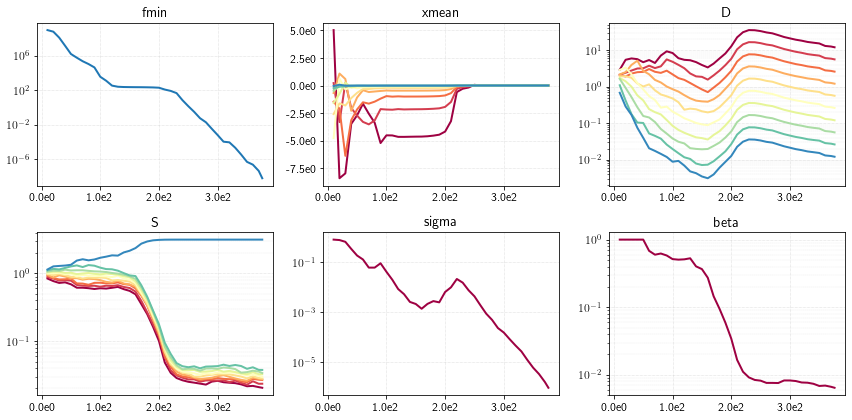

In [3]:
# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
xmean0 = np.random.randn(N)  # initial m
D0 = 2.0 * np.ones(N)        # initial D
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = np.random.randn(N)  # initial m
        D0 = 2.0 * np.ones(N)        # initial D
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

表示されている4列は左から，イテレーション数，目的関数評価回数，各イテレーションでのベスト解の目的関数値，これまでに得られたベスト解の目的関数値，を表しています．一番最後に，どの終了条件を満たして終了したかが表示されています．

## 使用したテスト関数の紹介


上のコードを実行した結果得られる最適化結果は，$d = 10$のEllipsoid-Cigar関数と呼ばれる関数
$$f(x) = 10^4 \sum_{i=1}^{d} \left(10^{3\frac{i-1}{d-1}} x_i\right)^2 + \frac{1 - 10^4}{d} \left(\sum_{i=1}^{d} 10^{3\frac{i-1}{d-1}} x_i\right)^2$$
を最適化した結果となります．この関数は凸二次関数ですが，変数毎に目的関数に与える影響が異なる（$10^{3\frac{i-1}{d-1}}$がかかっていることからわかります）ことに加え，$v = (1 / \sqrt{d}, \dots, 1 / \sqrt{d})$方向に対して目的関数が他の方向よりも鈍感である（第二項の影響です）といった特徴を持ちます．なお，この関数のヘッセ行列は
$$\nabla^2 f = 2 D_{\text{ell}} (10^4 I + (1 - 10^4) vv^T) D_{\text{ell}}$$
となります．ここで，$D_{\text{ell}} = \text{diag}(1, \dots, 10^{3\frac{i-1}{d-1}}, \dots, 10^{3})$です．また，その逆行列は
$$(\nabla^2 f)^{-1} = \frac{1}{2} D_{\text{ell}}^{-1} (10^{-4} I + vv^T) D_{\text{ell}}^{-1}$$
となります．


## DD-CMA-ESのアルゴリズムの紹介

DD-CMA-ESでは，多変量正規分布から複数の解を生成し，これらの目的関数を（多くの場合並列に）評価し，解のランキングを用いて多変量正規分布のパラメータを更新していきます．これを繰り返すことで，多変量正規分布を目的関数値の小さな（最小化を想定）領域へと収束させていきます．

DD-CMA-ESでは，多変量正規分布を$\mathcal{N}(m, \sigma^2 D C D)$ と表現します．ここで，$m \in \mathbb{R}^d$ は多変量正規分布の平均ベクトルを表し，プログラムやプロットにおいては xmean と書かれています．図のxmeanでは，$m$の各要素のイテレーション毎の変化がプロットされています．共分散行列は全体のスケーリングを表すステップサイズ $\sigma > 0$，要素毎のスケーリングを表す行列$D$（$d$次元対角行列），要素毎の相関を表す相関行列$C$の３つのパラメータを用いて表現されます．図のsigmaとDは$\sigma$と$D$の各要素を表しています．また，図中のSは相関行列$C$の$d$個の固有値の平方根の推移を表しています．なお，$\sigma D$がいわゆる分散行列であり，$D$自身も分布全体の大きさに関する情報を持っています．

今回の目的はアルゴリズムの解説ではないため，詳細は割愛します．[論文](https://direct.mit.edu/evco/article/28/3/405/94999/Diagonal-Acceleration-for-Covariance-Matrix#:~:text=https%3A//doi.org/10.1162/evco_a_00260)や[私が作成しているアルゴリズム解説用ノートブック](https://www.bbo.cs.tsukuba.ac.jp/research-j/cmaes%E9%80%B2%E5%8C%96%E6%88%A6%E7%95%A5%E3%81%AE%E8%A7%A3%E8%AA%AC)を参照してください．


## 結果の読み取り方

CMA-ESを理解し，活用していくうえで，上のような結果のグラフを解釈することが重要です．

複数の線がある xmean や D のプロットでは，赤系統がインデックスの小さな要素，青系統がインデックスの大きな要素に対応しています．S のプロットでは，固有値の平方根が昇順にソートされているので，カラーと要素のインデックスの間に関係はありません．

まず見るべきは，fmin です．これは，毎イテレーション生成されている解候補の中で，最小の目的関数値を表しています．最終的に望ましい解が得られているならば，実用上はそれ以上に議論する必要はないかもしれません．今回の問題では最適解の目的関数値は0であり，得られている解の目的関数値が指数的に減少している傾向が確認できます．

続いて，sigma を確認します．こちらも指数的に小さくなっていることがわかります．探索終了時点において，$\sigma^{(t)}/\sigma^{(0)} \approx 10^{-6}$程度になっていることから，初期の広がり$\sigma^{(0)}$と比較して十分に小さな分布になっていることがわかります．目的関数値が望ましい値なのかどうか以前に，正しく何らかの点に収束しているのかを見極めるためには，fmin でなく sigma を見ることが重要です．fmin が何らかの値で停滞しているように見える場合，収束しているのか，それとも探索が何らかの理由で進まなくなっているのかを fmin だけから見極めることは困難であるためです．例えば上の結果において，100〜200イテレーションの範囲において，目的関数値が停滞しているように見える箇所があります．目的関数値だけを見ていると，ここまでで収束したと見なしてしまうかもしれませんが，sigmaやSを見ると，共分散行列を適応している最中であることがわかります．

対角行列 D について注目すべきは，要素毎の比です．値が大きいということは，それだけその要素の方向に大きな標準偏差を多変量正規分布が持っていることになります．多変量正規分布がその方向に大きな広がりを持っているということは，目的関数が相対的にその方向への変化に対して鈍感であることを意味します．要素毎の目的関数値に与える感度が D によって学習されている様子が見て取れます．この結果から，この問題はインデックスの小さな変数が目的関数に与える影響は，インデックスの大きな変数が目的関数に与える影響よりも小さく，等高線を描いたとすれば各軸の長さの比が D の要素に比例した形になっているであろうことが予想されます．

最後に相関行列 C の固有値の平方根 S を確認します．イテレーション数が$2 \cdot 10^2$を超えたあたりから，S の最大の要素がその他の要素よりも$10^2$程度大きな値になっていることが見て取れます．これは，要素毎の感度をDが吸収したとしても，要素毎ではない何らかの１方向に対して目的関数に与える影響が鈍感な方向が存在していることがわかります．今回のテスト問題の場合，この方向は $v$ に対応しています．図からは読み取れませんが，以下のコードを実行すると，S の最大値に対応している固有ベクトルを確認することができます．

In [4]:
ddcma.B[:, -1]  
# B は S の各要素に対応する C の単位固有ベクトル．
# S は昇順にソートされているので，最大値に対応する固有ベクトルは B の最後の列

array([0.31623356, 0.31621514, 0.31623015, 0.31623169, 0.31623111,
       0.31620711, 0.31620877, 0.31623838, 0.31624005, 0.31624169])


経験的には，$D C D$は目的関数のヘッセ行列の逆行列$\nabla^2 f$に比例するような振る舞いが見られます．実際，今回の結果でも，$D$は$D_{\text{ell}}^{-1}$に概ね比例しており，$C$は$10^{-4} I + vv^T$に概ね比例していることが，上の実験結果からも確認されます．

#### まとめ：結果の図から分かること
- 十分に収束しているのか（sigma）
- 目的関数に対する感度が変数毎にどの程度異なるのか（D）
  - 感度が大きく異なる場合（例えばDの最大値と最小値の比が10以上），悪スケールな関数と呼ばれる
  - D の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - D の要素間の比が発散していくような場合，定式化時に注意が必要（後述）
- 変数間の依存関係が強いのか（S）
  - S の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - S の要素間の比が発散していくような場合，定式化時に注意が必要（後述）

目的関数値の推移だけを見て収束しているかどうかの判断をしてしまうのは危険です．必ず分布パラメータも見るようにしましょう．変数間依存性や悪スケール性のある問題（共分散行列を適応しなければ効率的に解けない問題）に対してCMA-ESは強力な方法ですが，共分散行列を適応している過程で目的関数値の減少が小さく見える場合が多くあります．

# 最適化実行前に検討すべき項目

最適化実行前に検討しておくべきこととしては，以下の３点が挙げられます
1. 目的関数評価回数 & 次元数
2. 初期分布パラメータ
3. ハイパーパラメータ（集団サイズ$\lambda$）
3. リスタート & 終了条件

## 1. 目的関数評価回数 & 次元数（CMA-ESを使うべきか）

まず，アルゴリズムの選択が不適切でないかを考えることが必要です．例えば，以下のような状況の場合には，CMA-ESよりも適切な方法があると考えられます．

- 次元数が高々５次元程度の場合：この場合，経験的にNelder-Mead法などの方が効率的であることが多く見られます．

- 許容できる実行時間内において，目的関数の評価回数が次元数の数十倍に満たない場合：この場合，CMA-ESは収束とみなせる程に分布が小さくなる前に終了してしまい，精度の高い解が得られない可能性が高いです．その場合，次元数が低い場合にはベイズ最適化のような最適化法を採用するか，さもなくばNelder-Mead法やその他の局所探索法，場合によってはベイズ最適化を採用したほうが現実的な時間内により望ましい解が得られる可能性が高いように思います．CMA-ESの場合，各イテレーションで生成される解候補は並列に評価することが可能なので，並列評価が可能なのであれば，これを考慮して最大評価回数を計算しましょう．

## 2. 初期分布パラメータ



初期分布のパラメータ $m^{(0)}$，$\sigma^{(0)}$, $D^{(0)}$, $C^{(0)}$ は，目的関数が複数の局所解を有する場合には重要な検討項目となります．ただし，予め変数毎のスケーリングなどを知らない限り$D^{(0)} = I$とし，変数間の依存関係などを知らない限り$C^{(0)} = I$とすることが自然です．以下，$m^{(0)}$と$\sigma^{(0)}$ について議論します．

- 有望な解の候補を知っている場合：例えば，既存の設計などの既存の解 $x_{\text{guess}}$ を持っている場合には，この解の周辺に初期化することが望ましいでしょう．これにより，少なくともこの初期解よりも優れた解の発見が期待できます．例えば，$m^{(0)} = x_{\text{guess}}$とし，$\sigma^{(0)}$を十分に小さな値とすれば，これを実現できます．ここで，$\sigma^{(0)}$は，対象としている問題毎に異なるでしょう．例えば，解の各要素が$10^{-4}$程度変化しただけではほとんど目的関数に影響しないであろう，などといった既存知識があるのであれば，$\sigma^{(0)} = 10^{-4}$などとすれば良いでしょう．変数毎にこの値が変わるようであれば，$\sigma^{(0)} = 1$とし，代わりに$D^{(0)}$の要素を変数毎に上と同様の方法で決定すれば良いでしょう．CMA-ESでは，分布の広がりが小さすぎる場合（すなわち大きく移動すれば目的関数を改善できるのに，広がりが狭すぎで移動できない場合），比較的高速に$\sigma$を大きくすることが可能なので，局所的な探索をしたい場合には，十分に小さな$\sigma^{(0)}$で初期化しておけば良いでしょう．

- 各設計変数の定義域が有限な場合 or 各設計変数の合理的な値の範囲を知っている場合：この場合，各設計変数の範囲$[L, U]$の中で，ランダムに初期化することが望ましいでしょう．例えば，$m^{(0)}_i \sim \mathcal{U}[L_i, U_i]$などと区間内の一様分布に従ってサンプリングし，$\sigma^{(0)} = 1$，$D^{(0)}_i = \frac{U_i - L_i}{4}$ などと初期化する方法が考えられます．ただし，$\sigma^{(0)}$については，より小さな値で初期化したほうがいい場合もあります．$\sigma^{(0)}$が大きいほど，特定の局所解に収束しがちになります．これが望ましい局所解であればよいのですが，そうでない場合，小さな$\sigma^{(0)}$としたほうが，多様な局所解を探索できる場合があります．

実際には，一度しか探索できないという場面は少ないでしょうから，有望な解の候補を知っている場合には，まずはその解を$m^{(0)}$，$\sigma^{(0)}$を適切に定めて探索し，その後$\sigma^{(0)}$を$10$倍して探索，$100$倍して探索，などと，徐々に大域的な探索を実行していくことが良いかと思います．なお，$\sigma^{(0)}$が大きくなるほど，$m^{(0)}$への依存性は下がっていきます．

### 2.1 10次元Rosenbrock 関数での例

Rosenbrock関数は
$$f(x) = \sum_{i=1}^{d-1} 100  \left(x_i^2 - x_{i+1}\right)^2 + \left( x_i - 1 \right)^2$$
と定義される四次関数です．最適解は$x^* = (1, \dots, 1)$となりますが，$(0, \dots, 0)$と$(1, \dots, 1)$をつなぐ曲線の周辺のみが低い目的関数値を取り，それ以外が相対的に高い目的関数値を取るような関数です．広い範囲を探索した場合，どこから探索してもまず原点付近に正規分布が一度集まるような傾向が見られます．

#### 確認事項
- 原点に平均ベクトルを初期化した場合，mode 1 ($\sigma^{(0)} = 1$)とmode 2 ($\sigma^{(0)} = 10^{-3}$)を比較することで，初期ステップサイズが小さすぎる場合には高速にこれを大きくできることを確認．
- 最適解周辺に平均ベクトルを初期化した場合，mode 3 ($\sigma^{(0)} = 10^{-1}$)とmode 4 ($\sigma^{(0)} = 1$)を比較することで，初期ステップサイズが十分に小さくないと局所探索にならない（良い解からスタートすることの意味があまりない）ことを確認．

#### 注意
初期ステップサイズを小さくしすぎた場合には，分布の発散を防ぐために標準で設けられている終了条件に引っかかってしまう恐れがある．その場合には初期ステップサイズが明らかに小さすぎるサインですので，10倍程度大きくして探索しましょう．

10 100 424.24577639192967 326.0067709644696
20 200 91.60426270221329 68.84347655010123
30 300 30.707512741976988 26.07831142830197
40 400 7.020769083139312 7.020769083139312
50 500 5.203287480613786 5.203287480613786
60 600 5.095628554265924 5.010108295657818
70 700 4.720269989120426 4.720269989120426
80 800 4.590279870214649 4.590279870214649
90 900 4.369890216273496 4.344939413403035
100 1000 4.057520996737941 4.022085159022027
110 1100 3.621972723390644 3.621972723390644
120 1200 3.344117885834992 3.304628215367951
130 1300 2.6470841766052176 2.6470841766052176
140 1400 2.228222962689565 2.172846197140752
150 1500 1.9725780854984798 1.9157899358911605
160 1600 1.6610703465296852 1.6289977804082219
170 1700 1.5213274246835697 1.5088169502397473
180 1800 1.3398747493641425 1.3398747493641425
190 1900 1.089817751920096 1.089817751920096
200 2000 0.9391017731567519 0.9153399198520065
210 2100 0.6110005499950959 0.5663867572410696
220 2200 0.46057418460884614 0.4556221530055868
230 2300 

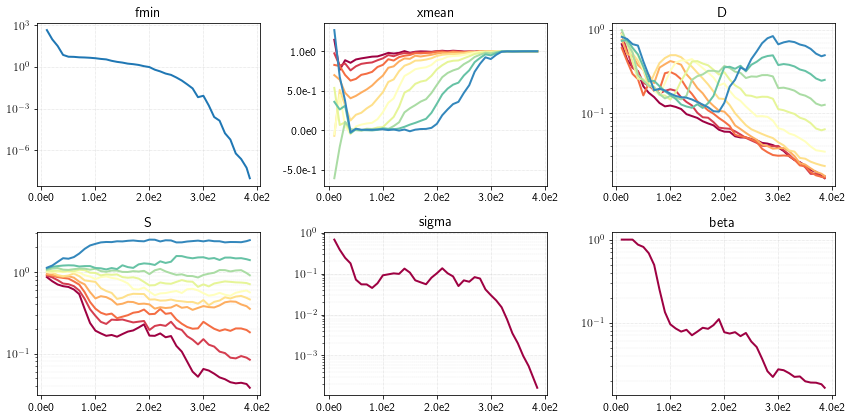

In [10]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rosenbrock(x):
    a = 1e2                
    return a * np.sum(
        (x[:, :-1]**2 - x[:, 1:])**2, axis=1) + np.sum(
            (x[:, :-1] - 1.0)**2, axis=1)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rosenbrock(xx)

# Setting for resart
NUM_RESTART = 1   # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 3
if mode == 0:
    # 原点に初期化
    xmean0 = np.zeros(N)
    D0 = 1e0 * np.ones(N)
elif mode == 1:
    # 原点に初期化（初期ステップサイズがかなり小さい場合）
    xmean0 = np.zeros(N)
    D0 = 1e-3 * np.ones(N)
elif mode == 2:
    # 最適解周りに初期化
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 3:
    # 最適解周りに初期化（初期ステップサイズが大きい場合）
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = np.random.randn(N)  # initial m
        D0 = 2.0 * np.ones(N)        # initial D
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

### 2.1 10次元Rastrigin 関数での例

Rastrigin関数は
$$f(x) = \sum_{i=1}^{d} x_i^2 + 10 ( 1 - \cos(2 \pi x_i))$$
と定義される多峰性関数（局所解を複数持つ関数）です．最適解は$x^* = (0, \dots, 0)$となりますが，各座標の値が整数の値付近において，局所解が存在します．ただし，巨視的に見ると下凸のような景観をしています．

#### 確認事項
- $m^{(0)}$を$(1, \dots, 1)$付近に初期化した場合，初期ステップサイズが十分に小さければ（ここでは$\sigma^{(0)} = 0.1$），局所的に目的関数値が改善されること．
- ただし，あくまで局所的にしか改善されないため，比較的大きな$\sigma^{(0)}$のほうが良い局所解へと収束する場合があること．当然，悪くなる場合もあること．

10 100 11.916591131762654 11.916591131762654
20 200 10.263941003351615 10.263941003351615
30 300 9.985894642999522 9.985894642999522
40 400 9.968949804665279 9.96300619964579
50 500 9.95167518136939 9.951612833293867
60 600 9.94992727227293 9.94992727227293
70 700 9.949761558011643 9.949705371959789
80 800 9.949603042065085 9.949603042065085
90 900 9.94959600421002 9.94959571418346
100 1000 9.949590992196033 9.949590992196033
110 1100 9.94959075284095 9.949590747200231
120 1200 9.949590608120523 9.949590608120523
130 1300 9.949590577392879 9.94959057620958
140 1400 9.949590571750909 9.949590571750909
150 1500 9.949590571249106 9.949590571164595
160 1600 9.949590570969146 9.949590570967707
170 1700 9.949590570936937 9.949590570936937
180 1800 9.949590570933438 9.949590570933344
190 1900 9.949590570933024 9.949590570933024


<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


200 2000 9.949590570932925 9.949590570932925
210 2100 9.949590570932916 9.949590570932914
Terminated with condition: bbob_tolhistfun


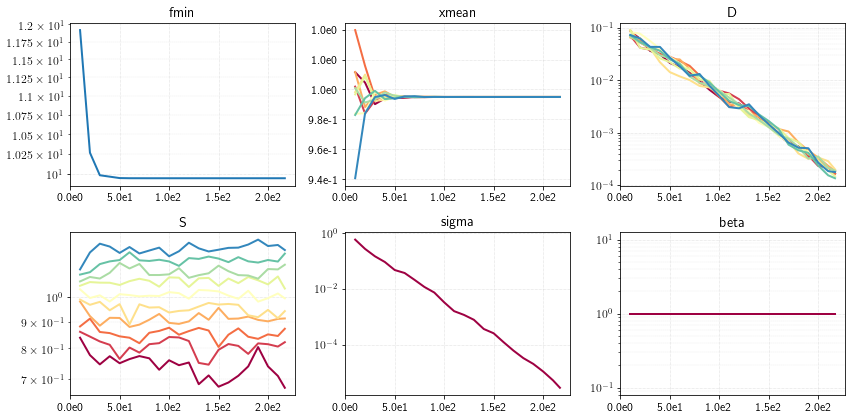

In [15]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 0
if mode == 0:
    # ステップサイズが小さい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 1:
    # ステップサイズが相対的に大きい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1.0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = np.random.randn(N)  # initial m
        D0 = 2.0 * np.ones(N)        # initial D
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 3. ハイパーパラメータ（集団サイズ$\lambda$）


CMA-ESのハイパーパラメータ全てに対して，最適化問題の次元数から求まる推奨値が設計されています．ただし，集団サイズ$\lambda$については，大きな値を与えることが望ましい場合があります．なお，$\lambda$を大きくすると，自動的に学習率などのパラメータの推奨値も変化します．

1. 目的関数の評価を，デフォルトの$\lambda$ ($= 4 + \lfloor 3 \log(d) \rfloor$)よりも多く並列計算可能である場合．一般に，$\lambda$を大きくすれば，探索に必要なイテレーション数は少なくなるため，探索終了までの実時間を削減することが可能です．ただし，$\lambda > d^2$程度になると，イテレーション数削減効果はほとんど見られなくなります．
2. 目的関数が多峰性関数である場合．集団サイズを大きくすることでより目的関数値の小さな局所解を得られる場合が多くあります．

### 3.1 並列化のために集団サイズを増加させる効果の確認


10次元 Ellipsoid-Cigar 関数を用いて，デフォルトの集団サイズの場合（$\lambda = 10$，一番上の図）と大きな集団サイズ$\lambda = 20, 40, 80, \dots$の場合のイテレーション数を比較します．位置イテレーションに必要な評価を全て並列計算できる場合，実行時間はイテレーション数に概ね依存します．

10 4000 426059.5368301105 426059.5368301105
20 8000 1247.9923245944083 1247.9923245944083
30 12000 5.402399234022596 5.402399234022596
40 16000 0.008279220575707985 0.008279220575707985
50 20000 9.23770420850345e-05 9.23770420850345e-05
60 24000 5.847898893032505e-07 5.847898893032505e-07
Terminated with condition: ftarget


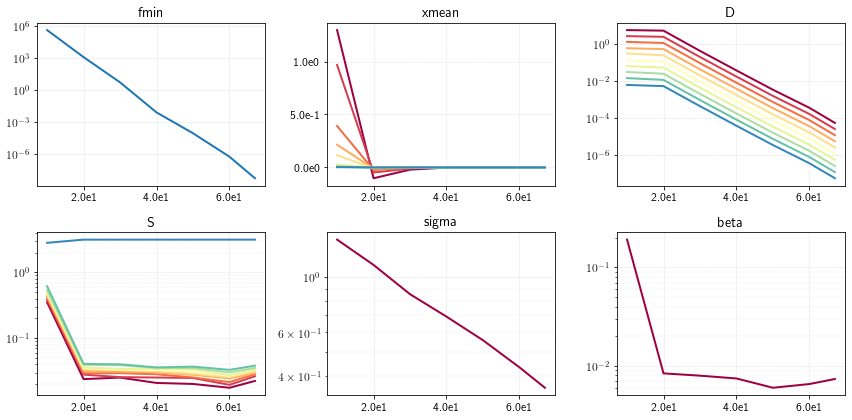

In [21]:
# 実行スクリプト
lam = 10

# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 1   # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=lam)  # 変更点はここ
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

集団サイズを大きくした場合に必要なイテレーション数が減少するのは，分布パラメータの更新に用いる学習率を大きく設定できる（推奨値もそのように設定されている）ためです．また，学習率の推奨値の設定から，$\lambda < 4d^2$程度まではイテレーション数の削減が確認できますが，それ以上ではイテレーション数は削減されません．

### 3.2 多峰性関数における集団サイズを増加させる効果の確認



上述のRastrigin関数のように，大域的に見れば下凸になっているようにみえる多峰性関数を大域的単峰な関数，もしくは大谷構造をもつ関数，などと呼びます．このような関数の場合，
- 初期ステップサイズを大きめに設定し，かつ，
- 集団サイズを大きめに設定

することで，目的関数値の低い局所解を獲得できる可能性があります．

#### 確認事項

- mode0とmode1を比較することで，集団サイズと初期ステップサイズがともに大きい場合には最適解発見確率が高くなるが，初期ステップサイズが小さすぎる場合には，集団サイズを大きくとっても局所探索になってしまうこと．

10 100 17.388547484674458 15.186449789018347
20 200 10.669279961078797 10.669279961078797
30 300 10.095994782012767 10.062492151836993
40 400 9.99397631055474 9.984481264205478
50 500 9.965887610543023 9.965456387249573
60 600 9.953223624812336 9.953223624812336
70 700 9.950450894715159 9.950450894715159
80 800 9.949885667392676 9.949845187818722
90 900 9.949621843604596 9.949621843604596
100 1000 9.949594596859939 9.949594596859939
110 1100 9.949592101916892 9.949592101916892
120 1200 9.949590778276749 9.949590734020138
130 1300 9.94959061730854 9.94959061730854
140 1400 9.949590577107632 9.949590577107632
150 1500 9.949590572359456 9.949590572359456
160 1600 9.94959057131241 9.94959057112562
170 1700 9.949590570939879 9.949590570939879
180 1800 9.949590570949209 9.949590570939879
190 1900 9.94959057093518 9.94959057093427
200 2000 9.949590570933324 9.949590570933191
210 2100 9.949590570933049 9.949590570933015
220 2200 9.949590570932932 9.94959057093293
230 2300 9.94959057093292 9.94

<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


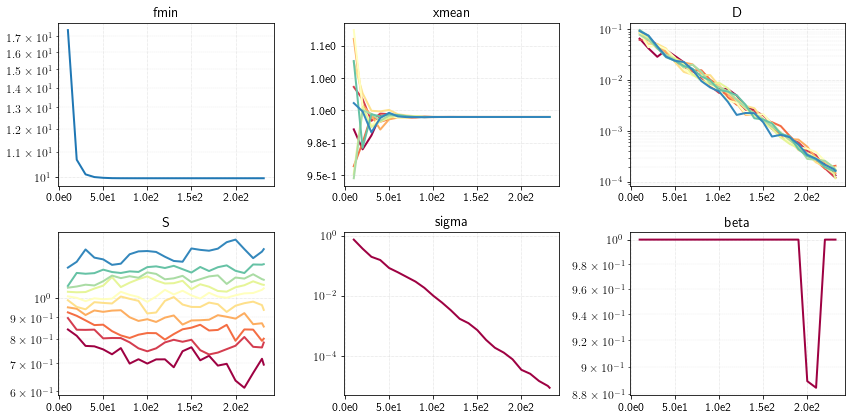

In [24]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1  # 局所解周辺に m を初期化
mode = 0
if mode == 0:
    # 集団サイズ大，初期ステップサイズ大
    lam = 200
    D0 = 2 * np.ones(N)
elif mode == 1:
    # 集団サイズ大，初期ステップサイズ小
    lam = 200
    D0 = 0.1 * np.ones(N)
elif mode == 2:
    # 集団サイズ小，初期ステップサイズ大
    lam = 10
    D0 = 2 * np.ones(N)
else:
    # 集団サイズ小，初期ステップサイズ小
    lam = 10
    D0 = 0.1 * np.ones(N) 


def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

一方で，例外も存在します．例えば，Double-Sphere関数（$s > 0$）
$$
f(x) = \min\left[ \sum_{i=1}^{d} (x_i - a_i)^2, d + s \sum_{i=1}^{d} (x_i - b_i)^2\right]
$$
がこれに該当します．この関数は二つの局所解しか持ちません．最適解は$a$で目的関数値が$f(a) = 0$，もう一つの局所解が$b$で目的関数値が$f(b) = d$となります．Rastrigin関数と異なり，大域的にみても二つの関数に分かれてしまっていることがわかります．また，$s$が小さい場合，局所解を形成する方の目的関数値のほうが小さい領域が広く存在しています．このような関数の場合，ステップサイズを大きくして大域的な探索を試みると，局所解の谷しか見えず（大域的最適解を形成する関数の領域に解が生成される確率が低い），局所解に収束する現象が見られます．このような関数を大域的多峰な関数であったり，UV構造を持つ関数などといいます．

#### 確認項目
Double Sphere関数の場合
- 初期ステップサイズを大きめに設定
- 集団サイズを大きめに設定
がいずれも逆効果になること

10 100 14.336227352237215 10.582964539476029
20 200 3.026875337437488 3.026875337437488
30 300 0.35760472130826354 0.35760472130826354
40 400 0.04791596153592314 0.04791596153592314
50 500 0.012694662138389946 0.00801719900798622
60 600 0.0006614006958658603 0.0006614006958658603
70 700 0.00014608627866212706 0.00013156671235736795
80 800 2.328174131657189e-05 2.03770202133777e-05
90 900 2.8816407336456796e-06 2.8816407336456796e-06
100 1000 1.0123080216000437e-06 8.559213231242649e-07
110 1100 1.2789629684273408e-07 1.2789629684273408e-07
120 1200 3.0835841579506436e-08 1.645489070157851e-08
Terminated with condition: ftarget


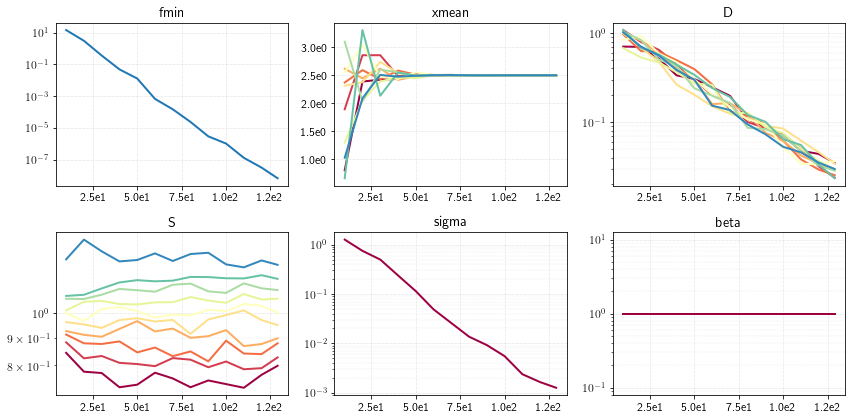

In [ ]:
# 実行スクリプト
N = 10
xmean0 = np.zeros(N)
mode = 3
if mode == 0:
    lam = 200
    D0 = 5.0 * np.ones(N)
elif mode == 1:
    lam = 200
    D0 = 1.0 * np.ones(N)
elif mode == 2:
    lam = 10
    D0 = 5.0 * np.ones(N)
else:
    lam = 10
    D0 = 1.0 * np.ones(N) 


def doublesphere(x):
    s = 0.2
    a = 2.5
    b = - np.sqrt((a**2 - 1) / s)
    f1 = np.sum((x[:, :] - a)**2, axis=1)
    f2 = N + s * np.sum((x[:, :] - b)**2, axis=1)
    return np.fmin(f1, f2)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = - np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return doublesphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 4. リスタート & 終了条件



一度の探索で望ましい解が得られる可能性は現実的にはかなり低いでしょう．その場合，繰り返し探索を行うことが必須となります．その際，前項目で見たように，集団サイズや初期分布パラメータを変えながらリスタートすることが望ましいです．そのようなリスタート戦略は，IPOPメカニズム，BIPOPメカニズムなどとして，提案されています．今回のコードでは，IPOPメカニズム（リスタート毎に集団サイズを倍にする方法）が実装されています．

リスタート戦略を用いる際，利用者が検討すべき項目は，各リスタートの終了条件です．終了条件が適切でないと，探索が終わっていないのに打ち切ってしまう，もしくはいつまでもリスタートがかからない，といった問題があります．

上のコードでは，
- 分布が小さくなったら終了
- 共分散行列の条件数が大きくなりすぎたら終了
- 目的関数値が一定イテレーション以上改善されなければ終了
- ある目的関数値に到達したら終了（この場合，リスタートもかけない）
- 最大の目的関数評価回数に達したら終了（この場合，リスタートもかけない）
などの終了条件が実装されています．分布の大きさや条件数に関する終了条件のしきい値は，計算誤差を考慮して予め設定されていますが，実際に解いている問題によっては，ある程度以上変数が変化しない限りほとんど目的関数に差は無いから無視して良い，もしくはある程度以上の精度で解を社会実装できないから，それ以上の精度はそもそも必要ない，などといった事前情報がある場合があるでしょう．その場合には，しきい値を事前情報によって調整することで，効率的な探索が可能になる可能性があります．

10 100 14.680347711671027 14.680347711671027
20 200 11.046075904604452 11.046075904604452
30 300 10.15651676365928 10.15651676365928
40 400 9.99665963728295 9.996447360452633
50 500 9.956246757128886 9.955922701490735
60 600 9.951078257530728 9.950738335050492
70 700 9.949718983663065 9.949696460458513
80 800 9.949617155567115 9.949616886080209
90 900 9.949593009149673 9.949592834203779
100 1000 9.949590723981911 9.949590677707674
110 1100 9.94959060876327 9.94959060876327
120 1200 9.949590578028785 9.949590578028785
130 1300 9.949590572714136 9.949590572714136
140 1400 9.949590571459607 9.949590571311834
150 1500 9.949590571029763 9.949590571012628
160 1600 9.949590570948578 9.949590570946459
170 1700 9.949590570935026 9.949590570935026
180 1800 9.949590570933253 9.949590570933253
190 1900 9.949590570932966 9.949590570932966
200 2000 9.94959057093293 9.949590570932926
210 2100 9.94959057093292 9.949590570932918
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20
10 200

<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


50 1000 54.766155249594284 44.208029067267695
60 1200 52.69424316875957 44.208029067267695
70 1400 33.07381417124504 26.538921427237362
80 1600 39.262778550984144 13.201106862710322
90 1800 9.983954686315164 6.290796927713864
100 2000 3.498858472483564 3.498858472483564
110 2200 3.115983356518912 3.072629876754066
120 2400 2.9944549566637284 2.9944549566637284
130 2600 2.9854400068016926 2.9854400068016926
140 2800 2.9849218406874534 2.9849218406874534
150 3000 2.9848788799331634 2.9848788799331634
160 3200 2.9848773305627767 2.9848773119764678
170 3400 2.984877178198777 2.9848771766059095
180 3600 2.9848771715729514 2.9848771715729514
190 3800 2.9848771713152464 2.9848771712921844
200 4000 2.9848771712828635 2.9848771712828635
210 4200 2.9848771712801243 2.9848771712801243
220 4400 2.9848771712799054 2.9848771712799054
230 4600 2.984877171279878 2.9848771712798774
Terminated with condition: bbob_tolhistfun
Restart with popsize: 40
10 400 71.48630646508315 54.19648161326372
20 800 73.9

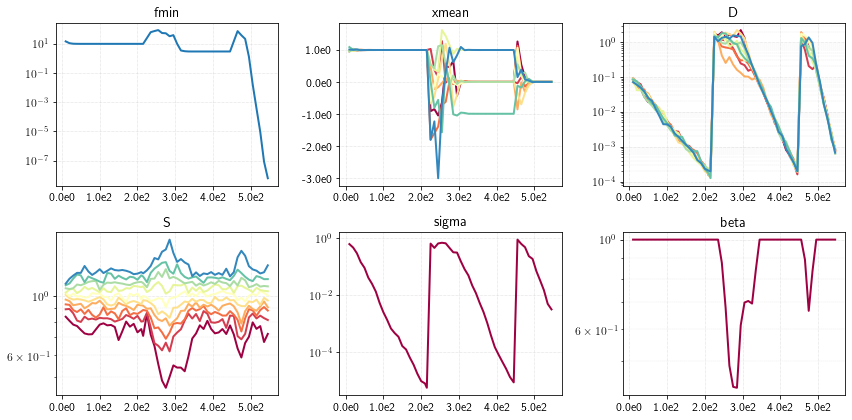

In [ ]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
D0 = 0.1 * np.ones(N)

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = np.random.randn(N)  # リスタート時の初期分布パラメータ
        D0 = np.ones(N) * 2.0        # リスタート時の初期分布パラメータ
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

# 定式化の見直し



最適化を実行してみたが望ましい解が得られない，という場面は多々あると思います．まず前項目までにみた検討項目について，十分な回数のリスタートがなされているのか，適切な終了条件が設定されているのか，初期分布パラメータは適切か，など，再度確認してみましょう．それでもうまく行かない場合，最適化問題の定式化を再検討することが必要になります．その際，分布パラメータの推移（上で出力しているような図）も確認しましょう．その中に，うまく解くためのヒントが隠されている場合があります．

ここでは，実際に起こりがちな，CMA-ESにとって解きにくい目的関数の設計と，そのときのCMA-ESの振る舞いをいくつか紹介します．

1. ほとんど平らな多峰性の目的関数 or 周期関数
2. 目的関数に影響を与えない変数
3. 尖った等高線を持つ目的関数

## 1. ほとんど平らな多峰性の目的関数 or 周期関数


CMA-ESは目的関数の値を直接用いず，複数の解のランキングに基づいて探索をしていきます．そのため，どれだけ勾配が小さくても，解の優越が正しく決定できる限り，勾配の小さな問題でも全く問題なく最適化ができます．例えば，
$$
f(x) = \sum_{i=1}^{d} x_i^2
$$
と
$$
f(x) = 20 - 20 \exp\left(-0.2 \sqrt{\frac{1}{d}\sum_{i=1}^{d} x_i^2}\right)
$$
は，単調増加変換の関係にあるため，CMA-ESからは等価な関数であるように扱われます．これは，目的関数のスケーリングを考慮しなくて良い，という観点で望ましい性質の一つです．

ただし，ここに多峰性が含まれると，注意すべき状況が発生します．例えば，上の関数に周期関数を加えた Ackley関数
$$
f(x) = 20 - 20 \exp\left(-0.2 \sqrt{\frac{1}{d}\sum_{i=1}^{d} x_i^2}\right) + \exp(1) - \exp\left(\frac{1}{d}\sum_{i=1}^{d} \cos(2\pi x_i)\right)
$$
を考えましょう．局所解は複数存在しますが，探索領域が$[-30, 30]^d$程度に制限されている場合，この関数はCMA-ESにとって，最適解$x^* = 0$を比較的容易に発見できる関数です．しかし，その探索領域が制限されていない場合，$[-30, 30]^d$の外側では追加された項$\exp(1) - \exp\left(\frac{1}{d}\sum_{i=1}^{d} \cos(2\pi x_i)\right)$が支配的になります．この場合，CMA-ESからみれば，ほとんど周期関数を複数の周期に渡って最適化しているように見えます．周期関数を複数周期に渡って探索しようとした場合，挙動が不安定になる場合があります．

#### 確認事項
以下，Ackley関数を，と，探索領域を設けて最適化した場合の比較です．
- 探索領域を設けずに最適化した場合（初期ステップサイズを30と比較的大きめに設定），$\sigma  D$ の値が以上に大きな値となり，収束できないか非常に効率が悪いこと
- 制約条件を設けることで，不安定な振る舞いを回避できること



10 100 20.719951863466264 19.213902811460752
20 200 20.419294449055613 18.963548253963666
30 300 19.46575792818441 18.571041587007368
40 400 19.34016527449955 18.571041587007368
50 500 19.82582724989388 18.097477057384445
60 600 16.07747958471674 15.21858768445809
70 700 8.580422247230503 8.580422247230503
80 800 6.108454624818339 6.108454624818339
90 900 3.59291475278801 3.399342782530498
100 1000 2.2145004448867427 2.0202369298119436
110 1100 0.7081212907749972 0.7081212907749972
120 1200 0.27909910433514096 0.27909910433514096
130 1300 0.11060874629213435 0.11060874629213435
140 1400 0.06795835071021816 0.06576057496920118
150 1500 0.02391978201273215 0.02391978201273215
160 1600 0.011512473689270664 0.010679094518930565
170 1700 0.00511421599852957 0.00511421599852957
180 1800 0.002450635806382273 0.002450635806382273
190 1900 0.0011478980315517973 0.0011478980315517973
200 2000 0.0005564517581806427 0.0004818917355899899
210 2100 0.0002529522205176882 0.0002529522205176882
220 220

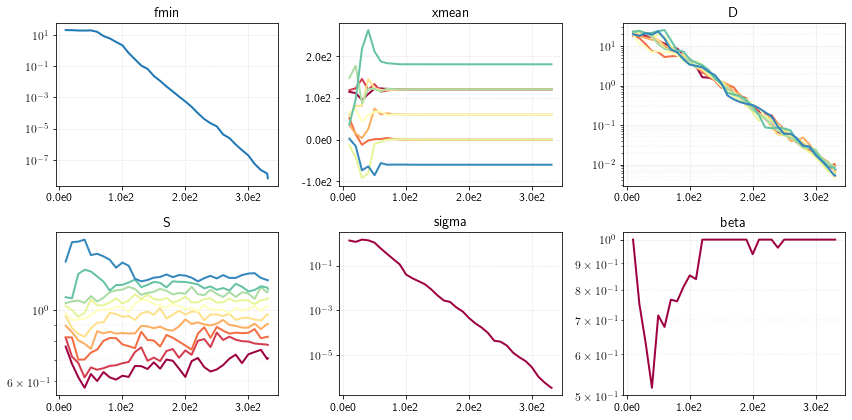

In [ ]:
# 実行スクリプト
# Ellipsoid-Cigar function
N = 10
xmean0 = 30 * np.random.rand(N)  # 恣意的に最適解からずらして初期化
D0 = 30 * np.ones(N)  # 探索領域の幅の1/4
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    f1 = a * (1 - np.exp(-b*np.sqrt(np.mean(x**2, axis=1))))
    f2 = np.exp(1) - np.exp(np.mean(np.cos(c * x), axis=1))
    return f1 + f2

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
if False:
    # 制約条件を考慮した場合
    LOWER_BOUND = -np.inf * np.ones(N)
    UPPER_BOUND = np.inf * np.ones(N)
else:
    # 制約条件を考慮しない場合
    LOWER_BOUND = -30.0 * np.ones(N)
    UPPER_BOUND = 30.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ackley(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = 30 * np.random.rand(N)  # 恣意的に最適解からずらして初期化
        D0 = 15 * np.ones(N)  # 探索領域の幅の1/4
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめ
- 最適解から遠く離れた領域の目的関数値が一定値に近づいていくようなケースでは，CMA-ESの振る舞いが不安定になり，探索が非効率になるか収束しないケースがあります．そのような目的関数を回避するか，合理的な設計変数の範囲が分かる場合には制約を設けましょう．
- $\sigma D$ の値が以上に大きくなっている現象が見られた場合，この問題が起こっている可能性が高いので，制約を設けるなどの工夫を試みてみると良いでしょう．

#### 補足（制約について）
制約を設けた場合に xmean が制約の外側に収束していないように見えるのは，ミラーリングという制約対処を用いており，制約の外側に仮想的な景観を作り出して探索しているためです．得られた xmean をミラーリングすると制約の内側の解が得られていることがわかります．

In [ ]:
print(ddcma.xmean)
print(mirror(ddcma.xmean, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC))

[ 6.00000000e+01 -6.00000000e+01  3.40687754e-10 -2.19390706e-09
  1.42467929e-09  3.36319764e-10 -7.26902380e-11  2.61021051e-09
  4.28846613e-10  1.46593218e-10]
[ 4.73028194e-09  1.24165922e-09  3.40687478e-10 -2.19390728e-09
  1.42468082e-09  3.36321193e-10 -7.26885219e-11  2.61021071e-09
  4.28848068e-10  1.46592072e-10]


## 2. 目的関数に影響を与えない変数



目的関数に影響を与えない変数が多く含まれる場合，それらを取り除いた場合と比較して探索効率が著しく悪化する現象が見られます．
このような冗長な変数は，例えばover-parameterizedな回帰モデルの係数を最適化する場合など，しばしば現れます．

例えば，$d = 20$次元のSphere関数
$$
f(x) = \sum_{i=1}^{d} x_i^2
$$
と$d = 100$次元であるがそのうち$20$個の変数しか意味を持たないsubspace-Sphere関数
$$
f(x) = \sum_{i=1}^{\lfloor d / 5 \rfloor} x_i^2
$$
で挙動を比較してみましょう．

#### 確認事項
- 本質的には同じ目的関数であるが，冗長な変数が存在すると$\sigma$の減少速度が遅くなり，収束までにより多くの評価回数を費やすこと
- 冗長な変数が存在する場合，共分散行列の条件数が発散していくこと（その結果，数値誤差が大きくなる恐れがある）

10 170 1376.7301910721076 1036.9912006065774
20 340 940.1879108234192 861.0971411609438
30 510 629.6740233056721 493.0981923645487
40 680 470.3981344174188 379.53283578715974
50 850 292.585811901449 281.5058987963641
60 1020 192.93347127786254 190.5557821417629
70 1190 109.0345982688606 71.90538066764681
80 1360 85.68400131526658 71.90538066764681
90 1530 56.68343073905691 52.74931986147689
100 1700 33.75769315682899 33.75769315682899
110 1870 25.003146995275475 25.003146995275475
120 2040 14.431512118799704 14.431512118799704
130 2210 10.81020845760434 9.444284626887379
140 2380 10.187015711506081 9.444284626887379
150 2550 6.390927257291691 6.3386802789918715
160 2720 3.7171554225652295 3.7171554225652295
170 2890 3.097148999808403 2.659759046339043
180 3060 2.399520183351659 2.399520183351659
190 3230 1.3282863638758324 1.2874304299592454
200 3400 0.8951729477758108 0.8951729477758108
210 3570 0.9264537893349516 0.6886716445949457
220 3740 0.5774545832502418 0.5774545832502418
230 3

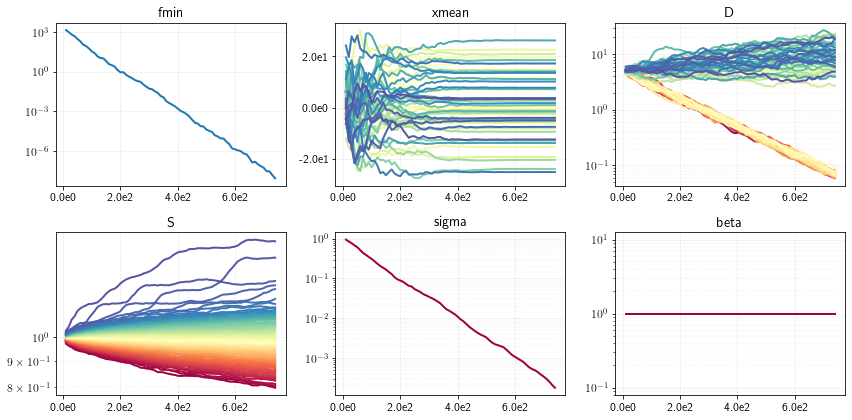

In [ ]:
# 実行スクリプト
mode = 0
if mode == 0:
    # 冗長な設計変数
    N = 100
    def subspace_sphere(x):
        dd = 50
        return np.sum(x[:, :dd]**2, axis=1)
elif mode == 1:
    # 冗長な設計変数を取り除いた場合
    N = 50
    def sphere(x):
        return np.sum(x[:, :]**2, axis=1)

xmean0 = 5 * np.random.rand(N)
D0 = 5 * np.ones(N) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    if mode == 0:
        return subspace_sphere(xx)
    else:
        return sphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = 5 * np.random.rand(N)
        D0 = 5 * np.ones(N) 
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめ
- 冗長な変数がある場合，
  - $\sigma$ の減少速度の低下による探索効率の低下
  - 共分散行列の条件数の発散
- 前者の問題は，冗長な変数の割合が少なければほとんど影響は現れないため，現実的な時間で最適化が進んでいれば特に気にする必要はないかもしれません
- 後者の問題は，求めたい設計変数の精度が高く精緻化が必要な場合には，条件数が発散することによる数値誤差の問題が発生し得ます．そのような場合，探索結果として得られた共分散行列を用いて，次元削減することをおすすめします．一例を以下にあげます．

In [ ]:
Cov = ddcma.transform(ddcma.transform(np.eye(ddcma.N)).T)  # 共分散行列を作成
eigval, eigvec = np.linalg.eigh(Cov)  # 固有値分解，eigvec[:, i] が eigval[i] に対応する単位固有ベクトル
print('共分散行列の固有値', eigval)  # 固有値の大きさが大きいもの（冗長な次元）と小さいもの（必要な次元）に分かれていることを確認

N = np.sum(eigval < 1e-8)  # 次元削減後の次元数
xbase = np.copy(ddcma.xmean)  # 前回探索時の平均ベクトルを座標系の原点とする
basis = np.copy(eigvec[:, :N])  # 次元削減後の基底

def reconstruct(x):
    # 次元削減後の（CMA-ESが新たに探索する）設計変数からもとの変数を復元
    return xbase + np.dot(x, basis.T)

共分散行列の固有値 [9.74873056e-11 1.02946647e-10 1.05317194e-10 1.06726426e-10
 1.11262498e-10 1.12270286e-10 1.14687093e-10 1.16235412e-10
 1.18599492e-10 1.19523181e-10 1.21811938e-10 1.25138718e-10
 1.25969669e-10 1.28639120e-10 1.30356207e-10 1.31556284e-10
 1.32570394e-10 1.33396132e-10 1.34881673e-10 1.37381177e-10
 1.38459609e-10 1.41752500e-10 1.42779632e-10 1.43841555e-10
 1.45521275e-10 1.48486305e-10 1.53321448e-10 1.55728895e-10
 1.56736698e-10 1.58293535e-10 1.61350415e-10 1.63027914e-10
 1.65937862e-10 1.71932436e-10 1.73275548e-10 1.74503896e-10
 1.75999661e-10 1.78066027e-10 1.81320925e-10 1.82608316e-10
 1.84775223e-10 1.85831504e-10 1.87488034e-10 1.91091864e-10
 1.92226454e-10 1.99374485e-10 2.08051524e-10 2.11426418e-10
 2.15364317e-10 2.52290234e-10 2.15253086e-07 4.35919707e-07
 4.55198569e-07 4.94006390e-07 5.32884268e-07 6.72985248e-07
 6.84601776e-07 7.18549668e-07 7.70788977e-07 8.53145648e-07
 8.81216008e-07 9.02847376e-07 9.07532211e-07 1.04605294e-06
 1.18606211e-0

10 150 43.58246199882906 34.201977033262615
20 300 11.69952561445009 11.69952561445009
30 450 7.041871926990687 7.041871926990687
40 600 3.6472774241519907 3.6472774241519907
50 750 1.3996526049191604 1.3996526049191604
60 900 1.0136909370041116 0.9828767113328246
70 1050 0.5712805220769148 0.5199164914982233
80 1200 0.33696303540430284 0.27906585991900107
90 1350 0.2381662859926635 0.2381662859926635
100 1500 0.1195437726012735 0.10993246278608143
110 1650 0.054542400723437405 0.0479024591524401
120 1800 0.03804593954995679 0.03465852165142899
130 1950 0.017695388913878403 0.016706084199845372
140 2100 0.00849946755426702 0.008315736910552866
150 2250 0.0041928886411290315 0.0041834539981104105
160 2400 0.0021281996316879067 0.001810252035366561
170 2550 0.0007172410710833366 0.0007172410710833366
180 2700 0.0005500767911181279 0.0005500767911181279
190 2850 0.0002510315423426315 0.00020657280202698072
200 3000 0.00016579888383832025 0.00014473850868640988
210 3150 6.688402936540086e-

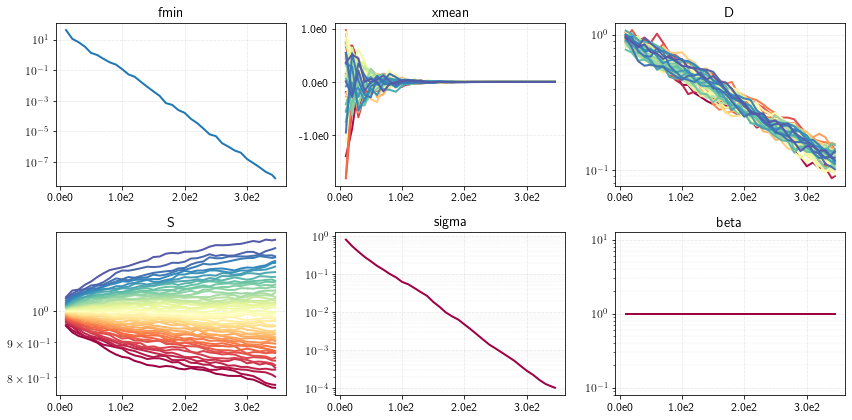

In [ ]:
# 実行スクリプト
xmean0 = np.zeros(N)  # 原点が前回探索した解なので，その周辺から始めることがおすすめ
D0 = np.ones(N) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return subspace_sphere(reconstruct(xx))  # CMA-ESが探索する空間は次元削減後の空間なので，目的関数にわたすときには reconstruct 

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        xmean0 = 5 * np.random.rand(N)
        D0 = 5 * np.ones(N) 
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')


## 3. 尖った等高線を持つ目的関数



CMA-ESは勾配を利用せず，また目的関数の値も直接は使用しないため，微分可能かどうかが直接は探索のしやすさに影響しません．例えば，なめらかな関数を単調増加変換した関数はなめらかになる保証はなく，勾配も定義されない可能性がありませんが，CMA-ESにとってはなめらかな関数と同等に扱われます．なめらかな関数の単調変換で表されるような関数は，等高線がなめらかになります．

一方，等高線が尖った目的関数の場合には，注意が必要です．
例えば，
$$
f(x) = \sum_{i=1}^{d} |x_i|
$$
という関数は，$x_i = 0$となる任意の点において，等高線が尖っていることが容易にわかります．これを一般化したものとして，
$$
f(x) = \left(\sum_{i=1}^{d} |x_i|^{p}\right)^{1/p}
$$
なども考えられます．$p$が小さい値になると，より尖った等高線となります．

等高線が尖っていても，その角度が0でなければ（例えば$p = 1$のケース），うまく探索できるでしょう．しかし，その角度が0になるケースでは，失敗する場合があります．

#### 確認事項
- $p = 1/4$のとき，デフォルトの集団サイズでは最適解でない微分不能な点に早期収束してしまう
- 集団サイズを増加させることで緩和することは可能

10 100 6.703089323495134 4.839036779630001
20 200 2.355447564867476 2.1769562311038646
30 300 0.7594449627687325 0.7256413497718492
40 400 0.3154193551975295 0.3154193551975295
50 500 0.127284928738975 0.09475894285784126
60 600 0.058098186530544105 0.048573514382195704
70 700 0.026528462233639694 0.026528462233639694
80 800 0.01048544965125231 0.009600868962657216
90 900 0.003997780170234222 0.0025872309032051177
100 1000 0.001736688283799026 0.001736688283799026
110 1100 0.000690778022478078 0.0005955875795740084
120 1200 0.0002904521384037295 0.0002766426435236724
130 1300 0.00011641387710614737 9.686434388811449e-05
140 1400 6.306202051398202e-05 4.431015414319006e-05
150 1500 2.9191311265108766e-05 2.3613948427758658e-05
160 1600 1.1567188431982345e-05 1.124593454449041e-05
170 1700 9.273909447493622e-06 7.530729477345233e-06
180 1800 2.2626402511605193e-06 2.2626402511605193e-06
190 1900 1.4699085904013032e-06 1.4699085904013032e-06
200 2000 5.708922268254923e-07 5.70892226825492

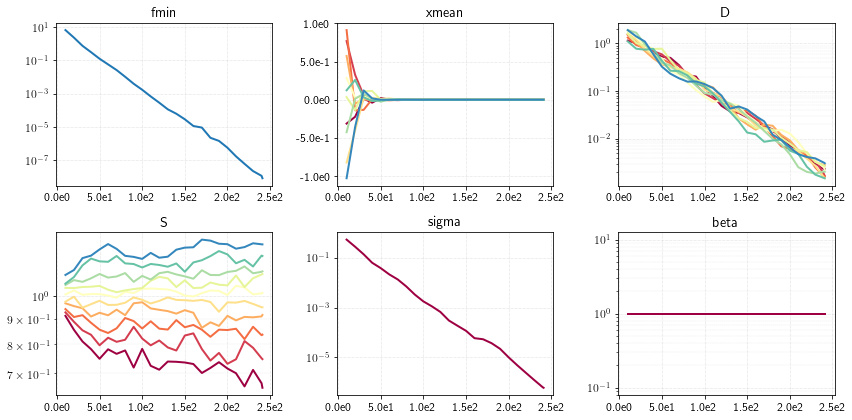

In [ ]:
# 実行スクリプト
N = 10

def pnorm(x):
    p = 1
    f = np.sum(np.abs(x)**p, axis=1)**(1/p)
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return pnorm(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめと対策
- 尖った等高線を持つ目的関数では探索に失敗することがある．特に，開き角度が$0$になるケースは注意．
- 多少の尖ったケースであれば，集団サイズを大きくすることで，対応可能です．集団サイズを大きくしながらリスタートする戦略を取っていれば，問題なく対応できる場合があります．ただし，定式化の段階で対応するに越したことはありません．
- 尖った等高線を持つ目的関数は，max や min，条件分岐がある場合に起こりやすい．可能であれば，max をなめらかな関数で近似するなどの工夫をしましょう．例えば，maxであればLogSumExp関数（$a > 0$）
$$
z_{\max} = \max(z_1, \dots, z_k) \approx \frac{1}{a} \log\left(\sum_{i=1}^{k} \exp(a z_i)\right) = z_{\max} + \frac{1}{a} \log\left(\sum_{i=1}^{k} \exp(a (z_i - z_\max))\right)
$$
であったり，Softmax関数を用いる方法が考えられます．
- 制約条件をペナルティ関数を用いて対処する場合も，尖った等高線を作り出しやすいので，注意が必要です．例えば，ある関数$g(x)$が$G$を超えてほしくない場合，$f(x) + c \max(g(x) - G, 0)$（$c$はペナルティ係数）といった方法がよく採用されますが，この場合も制約の境界上がなめらかでなくなる可能性があります．境界上の目的関数値が最適でない場合には，問題になりませんが，最適であるため境界上に収束することが必要になる場合には気をつけましょう．



## 4. 大域的多峰な目的関数



前述の通り，大域的多峰性を持つ関数の場合，最適化アルゴリズムサイドからアプローチしようとしても，集団サイズを大きくしても効果が無い，もしくは逆効果，となるため，初期値を変えながらリスタートを繰り返す力技に頼らざるを得ません．

この場合，目的関数の設計を工夫することで，回避できる場合もあります．例えば，目的関数とは別にある関数$g(x)$が存在し，望ましい解であれば$g(x)$の値も小さくなるはずである，という事前知識がある場合，これが活用できます．例えば，$f(x) + c g(x)$（$c > 0$）などとし，$c$をうまく調整することで，大域的最適な解へと誘導することができる場合もあります．

例えば，前述のdouble-Sphere関数を考えましょう．最適解の座標は各次元$a > 0$，もう一つの局所解の座標は各次元$b < 0$ となっていました．例えば事前知識として，$g(x) = \sum_{i=1}^{d}(x_i - 1)^2$が小さい解が望ましいといった情報を持っているとしましょう．このとき，上のように目的関数を変更することで，$g(x)$の値が小さくなるような解へと誘導することができます．ただし，そのようにして得られた解は，必ずしも$f(x)$の（局所）最適解ではないため，得られた解を初期解として，$f(x)$を局所探索すると良いでしょう．

#### 確認事項
Double-Sphere 関数を用いて
- 適切な関数$g$を用いることで，大域的最適解の谷へと誘導できること
- 得られた解を用いて局所探索することで，$f$の最適解が得られること

10 100 31.991619362684254 31.991619362684254
20 200 16.935888635904263 16.41122755533948
30 300 12.431859679732643 12.072699743617555
40 400 11.384910767244179 11.384910767244179
50 500 11.27583072769529 11.27583072769529
60 600 11.258472720130031 11.254562972787602
70 700 11.25290418180833 11.251544288351333
80 800 11.250444848895565 11.250444848895565
90 900 11.250129912180434 11.250072992590237
100 1000 11.250012039388423 11.25000730546816
110 1100 11.250002659373212 11.250001502852513
120 1200 11.250000248945025 11.250000248945025
130 1300 11.250000027820114 11.250000027820114
140 1400 11.250000004496222 11.250000004496222
150 1500 11.250000000928988 11.250000000928988
160 1600 11.25000000015645 11.25000000015645
170 1700 11.250000000063444 11.250000000060686
180 1800 11.250000000016005 11.250000000005965
190 1900 11.250000000001915 11.250000000001162
200 2000 11.250000000000288 11.250000000000288


<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


210 2100 11.250000000000036 11.250000000000036
220 2200 11.250000000000007 11.250000000000007
230 2300 11.25 11.25
Terminated with condition: bbob_tolhistfun


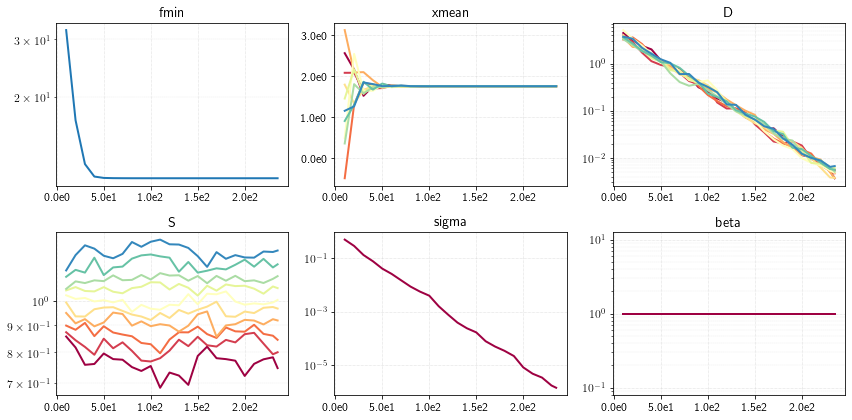

In [ ]:
# 実行スクリプト
N = 10
xmean0 = np.zeros(N)
D0 = 5.0 * np.ones(N)
lam = 10

def doublesphere(x):
    s = 0.2
    a = 2.5
    b = - np.sqrt((a**2 - 1) / s)
    f1 = np.sum((x[:, :] - a)**2, axis=1)
    f2 = N + s * np.sum((x[:, :] - b)**2, axis=1)
    return np.fmin(f1, f2)

def g(x):
    return np.mean((x - 1.0)**2, axis=1)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = - np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return doublesphere(xx) + 1e1 * g(xx)  # ガイドを追加

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

In [ ]:
xmean0 = np.copy(ddcma.xmean)
print(xmean0, doublesphere(xmean0.reshape((1, -1))))

[1.75       1.75000001 1.75       1.75       1.75       1.75
 1.75       1.75000001 1.75       1.74999999] [5.62499997]


10 100 1.1630943885242355 1.1630943885242355
20 200 0.4478618797786085 0.4478618797786085
30 300 0.08992404297754251 0.04454775323571741
40 400 0.015597237605085317 0.009852963490679838
50 500 0.0015346960836307836 0.0015346960836307836
60 600 0.0002775369146389672 0.0002775369146389672
70 700 7.44516809462021e-05 5.1773839127448184e-05
80 800 9.78419336506792e-06 9.030251112372358e-06
90 900 1.9391362638028705e-06 1.9391362638028705e-06
100 1000 3.207638824390869e-07 2.3539359958007434e-07
110 1100 3.103001628470842e-08 3.103001628470842e-08
120 1200 8.219783821970101e-09 8.219783821970101e-09
Terminated with condition: ftarget


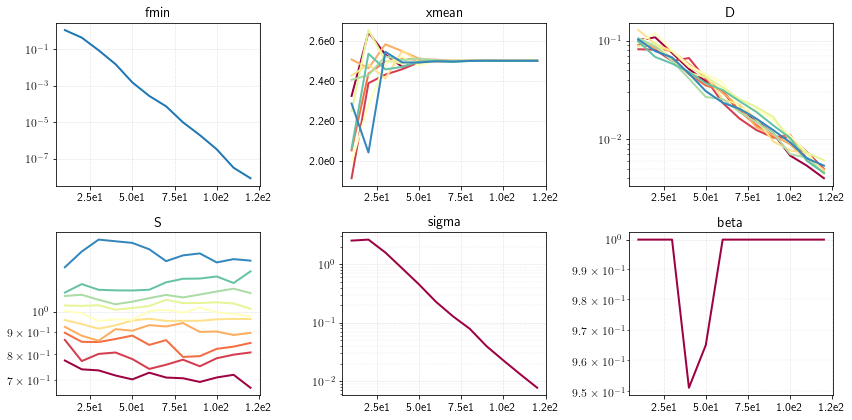

In [ ]:
# 実行スクリプト
N = 10
D0 = 0.1 * np.ones(N)  # 上のようにして最適化して得られた平均ベクトルを初期解として局所探索
lam = 10

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = - np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return doublesphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET and restart + 1 < NUM_RESTART:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## その他のトピック



#### 制約条件の対処
制約と一言でいっても，使える情報や計算時間など，状況は多岐に渡ります．矩形制約などは標準的に対応されている場合が多いものの，それ以外の制約はペナルティ関数を使うなどが一般的に利用しやすいでしょう．ただし，ペナルティ係数の設定によっては非常に解きにくい問題になってしまう，最適解が制約を違反してしまう，などの困難さがつきまといます．制約条件の性質毎に適切な制約対処法が異なるため，性質を良く検討した上で制約対処法を選択しましょう．

#### シミュレーション条件の不確実性
目的関数は基本的にシミュレーションを通して計算されると想定していますが，シミュレーションの条件が予め一意に定まるとは限りません．例えば，タイヤの設計をしている場合，路面状態によってグリップ性能は変わるでしょう．その場合，特定の状況を想定して最適化しても，他の状況では良くない解を得てしまう可能性があります．また，現実環境の情報が不足しているため，シミュレーション条件がそもそも不確実である，という場面も想定されます．その場合，考え得る最悪ケースの性能を最適化する，などの方法があります．シミュレーション環境が不確実な場合には，そのようなロバスト最適化などを検討しましょう．

#### 実行時間
目的関数の評価回数（シミュレーション回数）が少ない場合，CMA-ESよりもNelder-Mead法などを用いた局所探索をしたほうが，良い解を得られる場合があることを述べました．しかし，目的関数の評価回数が少なければ，あくまで局所的な探索しかできないことも事実です．大域的な探索を行いたい場合，シミュレーションの精度を落として高速に計算できるようにする方法が考えられます．ただ，愚直にこれを実装すると，シミュレーション精度が悪いので探索結果の信頼性が損なわれます．これに対して，シミュレーション精度をコントロールしながら最適化を進めていく，マルチフィデリティ最適化，という方針があります．シミュレーション時間がネックでありCMA-ESを活用できない場合には，この方針を検討してみましょう．

# おわりに

この資料がCMA-ESの利用者にとって少しでもCMA-ESをうまく活用する糧になればと思いますが，実応用上の困難さは多岐に渡るため，カバーしきれていないトピックも多くあります．どうしてもうまく行かないという場合には，秋本までご相談ください．